In [1]:
### We create our log file

In [1]:
## %matplotlib inline
import matplotlib.pyplot as plt
import requests, re, time
from bs4 import BeautifulSoup
import scraping_class
import pprint
import pandas as pd
import numpy as np
import pickle
import datetime as dt
logfile = 'log.csv'## name your log file.
connector = scraping_class.Connector(logfile)
session = requests.session()
session.headers['wmd776@alumni.ku.dk'] = 'wmd776@alumni.ku.dk' 
session.headers['Amalie_Tokkesdal'] = 'Amalie Tokkesdal'
session.headers


{'User-Agent': 'python-requests/2.21.0', 'Accept-Encoding': 'gzip, deflate', 'Accept': '*/*', 'Connection': 'keep-alive', 'wmd776@alumni.ku.dk': 'wmd776@alumni.ku.dk', 'Amalie_Tokkesdal': 'Amalie Tokkesdal'}

In [2]:
import requests

In [ ]:
url=[]
for n in range (1,5251,250):
    url.append('https://www.imdb.com/search/title/?title_type=feature&num_votes=20000,&sort=moviemeter,desc&count=250&start=' + str(n) + '&ref_=adv_nxt')
   


links = []
import time
for x in url:
    time.sleep(0.5)
    response = requests.get(x)
    if response.ok:
        html = response.text
    else:
        print('error')
    BeautifulSoup(html,'html.parser')
    link_location = html.split('href="')[1:]
    


    for link_loc in link_location:
        link = link_loc.split('"')[0].strip('title_type')      #-> check om det kan ekskluderes bagefter
        if '/title/' in link:
            links.append(link) 


links = ['https://www.imdb.com/'+link for link in links if not 'plotsummar' in link and not 'title_type' in link and not 'ref' in link and not 'plotsummary' in link and not 'vote' in link] # add the domain to each link
links=set(links)
links


In [ ]:
links=set(links)
len(links)


import pandas as pd
log_df = pd.read_csv('the_log.csv',sep=';') # load the ;-separated log 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

dt = log_df.dt.values[0]

import datetime
# Convert the time column 't' to datetime 
#log_df['dt'] = log_df.t.apply(datetime.datetime.fromtimestamp)
log_df['dt'] = pd.to_datetime(log_df.t,unit='s')

# Plot the time it took to make the call
plt.figure(figsize=(15,4))
plt.plot(log_df.dt,log_df.delta_t)
plt.ylabel('Delta t')
plt.xlabel('Scraping progress')
import datetime

# Plot the response size over time.
plt.figure(figsize=(15,4))
plt.ylabel('Size of response')
plt.xlabel('Scraping progress')
plt.plot(log_df.dt,log_df.response_size)

## Investigate errors
log_df.success.value_counts() ## Count errors
## Groupby time
# round the time for aggregation
log_df['dt_minute'] = log_df.dt.apply(lambda x: x-datetime.timedelta(seconds=x.second,microseconds=x.microsecond))
log_df['dt_hour'] = log_df.dt.apply(lambda x: x-datetime.timedelta(minutes=x.minute,seconds=x.second,microseconds=x.microsecond))
log_df.groupby('dt_hour').success.mean()

### Parsing HTML with BeautifulSoup

When parsing, we took advantage of the pyhton library BeautifulSoup. 

"BeautifulSoup makes the html tree navigable. 
It allows you to:
    * Search for elements by tag name and/or by attribute.
    * Iterate through them, go up, sideways or down the tree.
    * Furthermore it helps you with standard tasks such as extracting raw text from html,
    which would be a very tedious task if you had to hardcode it using `.split` commands and using your own regular expressions will be unstable."

In [12]:
def find_budget(soup):
    for i in soup.find(id="titleDetails").find_all("div", class_="txt-block"):
        if i.find().text == "Budget:":
            return float(i.text.strip().split("\n")[0].split("$")[1].replace(",", ""))
        
def find_gross(soup):
    for i in soup.find(id="titleDetails").find_all("div", class_="txt-block"):
        if i.find().text == "Cumulative Worldwide Gross:":
            return float(i.text.strip().split("\n")[0].split("$")[1].replace(",", ""))
        
def find_grossUSA(soup):
    for i in soup.find(id="titleDetails").find_all("div", class_="txt-block"):
        if i.find().text == "Gross USA:":
            return float(i.text.strip().split("\n")[0].split("$")[1].replace(",", ""))

def find_rating(soup):
    for i in soup.find(id="title-overview-widget").find_all("div", class_="ratingValue"):
        return float(i.text.strip().split("/")[0])
        
def find_runtime(soup):
    for i in soup.find(id="titleDetails").find_all("div", class_="txt-block"):
        if i.find().text == "Runtime:":
            return float(i.text.strip().split("\n")[1].split("min")[0].strip())
def find_date(soup):
    for i in soup.find(id="titleDetails").find_all("div", class_="txt-block"):
        if i.find().text == "Release Date:":
            return i.text.strip().split(":")[1].split("(")[0].strip()
        
def find_genre(soup):
    for i in soup.find(id="title-overview-widget").find_all("div", class_="subtext"):
        if str(i.text.strip().split("|")[2].replace('\n','').replace(' ','').split(","))[-3]==(')'):
            return i.text.strip().split("|")[1].replace('\n','').replace(' ','').split(",")
        else:
            return i.text.strip().split("|")[2].replace('\n','').replace(' ','').split(",")


### Parsing and cleaning the data 

Here we use our earlier defined functions to make a dictionary of all the data we need from the description page of each movie, ie. title, budget, the cumulative worldwide gross, the rating, the runtime, date and genre.


In [13]:
def page_extractor(url):
    r, call_id = connector.get(url, "LOL")
    try:
        soup = BeautifulSoup(r.text, "html.parser")
        title = soup.select("#title-overview-widget > div.vital > div.title_block > div > div.titleBar > div.title_wrapper > h1")[0].text.split("\xa0")[0]
        budget = find_budget(soup)
        cumulative_worldwide_gross=find_gross(soup)
        gross_usa=find_grossUSA(soup)
        rating = find_rating(soup)
        runtime = find_runtime(soup)
        date= find_date(soup)
        genre = find_genre(soup)
    except:
        soup = None
        title = None
        budget = None
        cumulative_worldwide_gross= None
        gross_usa = None
        rating=None
        runtime = None
        date = None
        genre = None
    return {
        "title": title,
        #"year": year,
        "budget": budget,
        "url": url,
        "cumulative_world_gross": cumulative_worldwide_gross,
        "gross_usa": gross_usa,
        "rating": rating,
        "runtime": runtime,
        "date": date,
        "genre": genre
    }


### Create a list and append information from every movie on the list. 
Remark: We have only chosen top 250 so far, as to not make the coding too slow in progress. If you wish to see the whole list, or a minor part of it, simply change the brackets after 'links'.



In [14]:
# res = []
# for idx, i in enumerate(links):
#     print(idx + 1, "of", len(links))
#     res.append(page_extractor(i))


### Making our list into a dataframe, and applying datetime to the releasedate

A dataframe is basically just when a list has both several columns and rows, if there's only one row it's an array.

Remember to comment on the string lengths need to be over 4 characters.


In [15]:
# df = pd.DataFrame(res).dropna()

# df = df[df['date'].str.len() > 4]

# def preparedatetime(dataframe):
#     dataframe['datetime'] = pd.to_datetime(dataframe['date'], format = '%d %B %Y')
#     dataframe['year'] = dataframe.datetime.dt.year
#     dataframe['month'] = dataframe.datetime.dt.month
#     dataframe['day'] = dataframe.datetime.dt.day
#     return dataframe

# df = preparedatetime(df)
# df
# df.to_pickle('all_movies.csv') #saves relatively as csv 
#df.to_pickle('all_movies.pkl')
# #This command will load dataset from pkl or csv file
# df = pd.read_pickle('all_movies.csv')
# # or
df = pd.read_pickle('all_movies.pkl')
df

,budget,cumulative_world_gross,date,genre,gross_usa,rating,runtime,title,url,datetime,year,month,day
1,110000000.0,7.122059e+08,17 November 2011,"[Action, Adventure, Drama]",281287133.0,4.9,117.0,Breaking Dawn - del 1,https://www.imdb.com//title/tt1324999/,2011-11-17,2011,11,17
2,3500000.0,1.950404e+07,29 September 2011,"[Drama, Thriller]",5354039.0,7.1,107.0,Giftig viden,https://www.imdb.com//title/tt1615147/,2011-09-29,2011,9,29
3,56600000.0,6.942439e+07,21 January 2005,"[Drama, Mystery, Romance]",6524389.0,7.6,133.0,En lang forlovelse,https://www.imdb.com//title/tt0344510/,2005-01-21,2005,1,21
4,175000000.0,1.734188e+08,27 July 2007,"[Comedy, Family, Fantasy]",100462298.0,5.4,96.0,"Du almægtige, Evan",https://www.imdb.com//title/tt0413099/,2007-07-27,2007,7,27
6,8000000.0,1.005232e+08,17 November 2006,"[Comedy, Drama]",59891098.0,7.8,101.0,Little Miss Sunshine,https://www.imdb.com//title/tt0449059/,2006-11-17,2006,11,17
7,78000000.0,1.792652e+08,26 September 2003,"[Action, Adventure, Fantasy]",66465204.0,5.8,110.0,Det hemmelighedsfulde selskab,https://www.imdb.com//title/tt0311429/,2003-09-26,2003,9,26
8,25000000.0,1.341196e+07,3 June 2005,"[Biography, Drama, Sport]",11273517.0,7.1,107.0,Lords of Dogtown,https://www.imdb.com//title/tt0355702/,2005-06-03,2005,6,3
9,14000000.0,1.434303e+07,24 May 2002,[Comedy],14254993.0,4.6,87.0,Freddy Got Fingered,https://www.imdb.com//title/tt0240515/,2002-05-24,2002,5,24
10,15000000.0,8.064053e+07,25 March 1988,"[Comedy, Drama, Romance]",80640528.0,7.1,102.0,Lunefulde måne,https://www.imdb.com//title/tt0093565/,1988-03-25,1988,3,25
12,12000000.0,5.222331e+07,29 November 2002,"[Drama, Thriller]",31597131.0,6.8,96.0,One Hour Photo,https://www.imdb.com//title/tt0265459/,2002-11-29,2002,11,29


In [16]:
categories = set()
for i in df["genre"].apply(set).tolist():
    for j in i:
        categories.add(j)
#categories= set(['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family',
#                'Fantasy', 'Film-Noir', 'Game-Show', 'History', 'Horror', 'Music', 'Musical', 'Mystery', 'News',
#                'Reality-TV', 'Romance', 'Sci-Fi', 'Sport', 'Talk-Show', 'Thriller'])
df2 = pd.concat([df, pd.DataFrame(columns=categories)], axis=1)


In [17]:
def df_dummy(df, col):
    return df.apply(lambda x: col in x["genre"], axis=1)

for i in categories:
    df2[i] = df_dummy(df2, i)
    df2[i] = pd.get_dummies(df2[i], drop_first = True)


df2 = df2.set_index(df['title'])
del df2['title']

df2


,budget,cumulative_world_gross,date,genre,gross_usa,rating,runtime,url,datetime,year,...,Mystery,Musical,Biography,Drama,Thriller,Music,Family,Sport,Horror,Action
title,,,,,,,,,,,,,,,,,,,,,
Breaking Dawn - del 1,110000000.0,7.122059e+08,17 November 2011,"[Action, Adventure, Drama]",281287133.0,4.9,117.0,https://www.imdb.com//title/tt1324999/,2011-11-17,2011,...,0,0,0,1,0,0,0,0,0,1
Giftig viden,3500000.0,1.950404e+07,29 September 2011,"[Drama, Thriller]",5354039.0,7.1,107.0,https://www.imdb.com//title/tt1615147/,2011-09-29,2011,...,0,0,0,1,1,0,0,0,0,0
En lang forlovelse,56600000.0,6.942439e+07,21 January 2005,"[Drama, Mystery, Romance]",6524389.0,7.6,133.0,https://www.imdb.com//title/tt0344510/,2005-01-21,2005,...,1,0,0,1,0,0,0,0,0,0
"Du almægtige, Evan",175000000.0,1.734188e+08,27 July 2007,"[Comedy, Family, Fantasy]",100462298.0,5.4,96.0,https://www.imdb.com//title/tt0413099/,2007-07-27,2007,...,0,0,0,0,0,0,1,0,0,0
Little Miss Sunshine,8000000.0,1.005232e+08,17 November 2006,"[Comedy, Drama]",59891098.0,7.8,101.0,https://www.imdb.com//title/tt0449059/,2006-11-17,2006,...,0,0,0,1,0,0,0,0,0,0
Det hemmelighedsfulde selskab,78000000.0,1.792652e+08,26 September 2003,"[Action, Adventure, Fantasy]",66465204.0,5.8,110.0,https://www.imdb.com//title/tt0311429/,2003-09-26,2003,...,0,0,0,0,0,0,0,0,0,1
Lords of Dogtown,25000000.0,1.341196e+07,3 June 2005,"[Biography, Drama, Sport]",11273517.0,7.1,107.0,https://www.imdb.com//title/tt0355702/,2005-06-03,2005,...,0,0,1,1,0,0,0,1,0,0
Freddy Got Fingered,14000000.0,1.434303e+07,24 May 2002,[Comedy],14254993.0,4.6,87.0,https://www.imdb.com//title/tt0240515/,2002-05-24,2002,...,0,0,0,0,0,0,0,0,0,0
Lunefulde måne,15000000.0,8.064053e+07,25 March 1988,"[Comedy, Drama, Romance]",80640528.0,7.1,102.0,https://www.imdb.com//title/tt0093565/,1988-03-25,1988,...,0,0,0,1,0,0,0,0,0,0


# Ratings function (main function)
## Will scrape each ranking URL from relevant data.
### Title is gathered by selector while the rankings are gathered by HTML converted into list which then is calculated

In [18]:
################### sub function making a list and from list created variables in main function ###################
def find_ratings(soup, rate):        
    for i in soup.select("#main > section > div > table:nth-child(14)")[0].find_all('div', class_='bigcell'):
        rate.append(i.text)
# find_ratings(BeautifulSoup(requests.get("https://www.imdb.com//title/tt0266543/ratings").text, "html.parser"))        
# rate


def ratings_extractor(url):
    r_r, call_id = connector.get(url, "ROFLMAO")
    soup_ = BeautifulSoup(requests.get(url).text, "html.parser")
    rate = []
    try:
        title = soup_.select("#main > section > div > div.subpage_title_block > div > div.parent > h3 > a")[0].text
        find_ratings(soup_,rate)
        check = [float(i) for i in rate]
        rate_all = [float(i) for i in rate][0]
        rate_young = float(round(np.array(list(np.array([float(i) for i in rate])[[1, 2, 6, 7, 11, 12]])).sum()/6, 2)) 
        rate_old = float(round(np.array((np.array([float(i) for i in rate])[[3,4,8,9,13,14]])).sum()/6, 2))
        rate_male = [float(i) for i in rate][5]
        rate_female = [float(i) for i in rate][10]
    except:
        title = None
        rate_all = None
        rate_young = None
        rate_old = None
        rate_male = None
        rate_female = None
    return {
        'title': title,
        'rate_all': rate_all,
        'rate_young': rate_young,
        'rate_old': rate_old,
        'rate_male': rate_male,
        'rate_female': rate_female
        }
ratings_extractor('https://www.imdb.com//title/tt0218817/ratings') #fordi den bliver None, skal de fjernes efter

{'rate_all': None,
 'rate_female': None,
 'rate_male': None,
 'rate_old': None,
 'rate_young': None,
 'title': None}

# Gathering all titles and their rankings using main function. 
## Each ranking url has it's own dictionary. Each dictionary is stored as a list

In [19]:
# rankings for each films are stored in links_r
links_r = [x+'ratings' for x in links]
res_r = []
# for idx, i in enumerate(links_r):
#     print(idx + 1, "of", len(links_r))
#     res_r.append(ratings_extractor(i))

# Translating the list of dictionaries into a DataFrame
## rankings-DataFrame

In [20]:
# df_r = pd.DataFrame(res_r).dropna() #dropper de film der mangler ratings fra en bestemt gruppe


# df_r.to_pickle('all_ratings.pkl') #husk kun at brug når data skal uploades/gemmes
df_r = pd.read_pickle('all_ratings.pkl').dropna() #husk kun at brug når data skal downloades/hentes
df_r = df_r.set_index(df_r['title'], drop=True)
del df_r['title']



# Merging movie-attribute-DataFrame with rankings-DataFrame, using innerjoin on the movie titles

In [21]:
df_master = pd.merge(df2, df_r, on='title', how='inner')

df_master = df_master.drop("Fetih 1453", axis=0)
df_master['cumulative_world_gross']=round(df_master['cumulative_world_gross']/1000000,3)
df_master['budget']=df_master['budget']/1000000
df_master['profit']=(df_master['cumulative_world_gross']-df_master['budget'])
df_master['return'] = round(df_master['cumulative_world_gross']/df_master['budget'],2)
df_master['gross_usa']=round(df_master['gross_usa']/1000000,2)
df_master

df_master = df_master.drop(df_master[df_master['return'] > 15].index)
#note that https://www.imdb.com//title/tt1783232/ has a budget of 18 dollars while grossing 35 million dollar.
df_master.loc[df_master['return'].idxmax()]
#It should've been 18 mio according to google.

df_master

,budget,cumulative_world_gross,date,genre,gross_usa,rating,runtime,url,datetime,year,...,Sport,Horror,Action,rate_all,rate_female,rate_male,rate_old,rate_young,profit,return
title,,,,,,,,,,,,,,,,,,,,,
Breaking Dawn - del 1,110.0,712.206,17 November 2011,"[Action, Adventure, Drama]",281.29,4.9,117.0,https://www.imdb.com//title/tt1324999/,2011-11-17,2011,...,0,0,1,4.9,5.8,4.3,5.13,5.18,602.206,6.47
Giftig viden,3.5,19.504,29 September 2011,"[Drama, Thriller]",5.35,7.1,107.0,https://www.imdb.com//title/tt1615147/,2011-09-29,2011,...,0,0,0,7.1,6.9,7.1,7.12,7.20,16.004,5.57
En lang forlovelse,56.6,69.424,21 January 2005,"[Drama, Mystery, Romance]",6.52,7.6,133.0,https://www.imdb.com//title/tt0344510/,2005-01-21,2005,...,0,0,0,7.6,7.7,7.6,7.63,8.38,12.824,1.23
"Du almægtige, Evan",175.0,173.419,27 July 2007,"[Comedy, Family, Fantasy]",100.46,5.4,96.0,https://www.imdb.com//title/tt0413099/,2007-07-27,2007,...,0,0,0,5.4,5.6,5.3,5.53,5.67,-1.581,0.99
Little Miss Sunshine,8.0,100.523,17 November 2006,"[Comedy, Drama]",59.89,7.8,101.0,https://www.imdb.com//title/tt0449059/,2006-11-17,2006,...,0,0,0,7.8,7.9,7.8,7.80,7.98,92.523,12.57
Det hemmelighedsfulde selskab,78.0,179.265,26 September 2003,"[Action, Adventure, Fantasy]",66.47,5.8,110.0,https://www.imdb.com//title/tt0311429/,2003-09-26,2003,...,0,0,1,5.8,6.2,5.8,5.90,5.95,101.265,2.30
Lords of Dogtown,25.0,13.412,3 June 2005,"[Biography, Drama, Sport]",11.27,7.1,107.0,https://www.imdb.com//title/tt0355702/,2005-06-03,2005,...,1,0,0,7.1,7.3,7.1,6.93,7.40,-11.588,0.54
Freddy Got Fingered,14.0,14.343,24 May 2002,[Comedy],14.25,4.6,87.0,https://www.imdb.com//title/tt0240515/,2002-05-24,2002,...,0,0,0,4.6,3.9,4.7,4.00,4.87,0.343,1.02
Lunefulde måne,15.0,80.641,25 March 1988,"[Comedy, Drama, Romance]",80.64,7.1,102.0,https://www.imdb.com//title/tt0093565/,1988-03-25,1988,...,0,0,0,7.1,7.3,7.0,7.18,7.52,65.641,5.38


# Deskriptiv statistik

In [22]:
def category_summary(df, category, categories):
    categories = list(categories)
    stats = ["rate_all", "rate_female", "rate_male", "rate_old", "rate_young"]
    df_ = df[stats + categories]
    df_ = df_[df_[category] == 1]
    return df_[stats].mean() 




print(category_summary(df_master, "Fantasy", ["Fantasy"])) #examples
print(category_summary(df_master, "Horror", ["Horror"])) #exmaples

rated = []
for idx, i in enumerate(categories):
    print(idx+1, 'of', len(categories))
    rated.append(category_summary(df_master, i, [i]))
    
# rated 
df_rated=pd.DataFrame(rated, index=categories)
df_rated

#Check at categories er defineret ud fra hvilke genre der rent faktisk er i datasættet

rate_all       6.420186
rate_female    6.614907
rate_male      6.354658
rate_old       6.427919
rate_young     6.580528
dtype: float64
rate_all       6.098870
rate_female    6.155932
rate_male      6.071751
rate_old       6.080706
rate_young     6.192571
dtype: float64
1 of 21
2 of 21
3 of 21
4 of 21
5 of 21
6 of 21
7 of 21
8 of 21
9 of 21
10 of 21
11 of 21
12 of 21
13 of 21
14 of 21
15 of 21
16 of 21
17 of 21
18 of 21
19 of 21
20 of 21
21 of 21


,rate_all,rate_female,rate_male,rate_old,rate_young
Film-Noir,8.200000,8.100000,8.200000,8.185000,8.375000
War,7.463462,7.507692,7.438462,7.414231,7.650192
Adventure,6.524935,6.683159,6.480679,6.515000,6.658943
Sci-Fi,6.498187,6.554381,6.479758,6.470423,6.556798
Western,7.277778,7.222222,7.266667,7.231111,7.460000
Romance,6.602311,6.729412,6.507983,6.545294,6.843004
Crime,6.675662,6.716887,6.656623,6.604437,6.957997
Comedy,6.409483,6.505334,6.349873,6.344801,6.624691
Animation,6.888235,7.069608,6.828431,6.847108,6.935588
Fantasy,6.420186,6.614907,6.354658,6.427919,6.580528


In [23]:
def genre_stats(df, category, categories):
    categories = list(categories)
    stats = ["cumulative_world_gross", "budget", 'rating']
    df_ = df[stats + categories]
    df_ = df_[df_[category] == 1]
    return df_[stats].mean() 
#husk at inkluder antallet af observationer pr. genre

print(genre_stats(df_master, "Musical", ["Musical"]))


money = []
for idx, i in enumerate(categories):
    money.append(genre_stats(df_master, i, [i]))
    
# rated 
df_money=pd.DataFrame(money, index=categories)
df_money['genres']=categories
df_money['cumulative_world_gross']=round(df_money['cumulative_world_gross'],2)
df_money['budget']=round(df_money['budget'],2)
df_money['profit']=(df_money['cumulative_world_gross']-df_money['budget'])
df_money['return']=round(df_money['cumulative_world_gross']/df_money['budget'],2)
df_money['rating']=round(df_money['rating'],2)

df_money

cumulative_world_gross    118.442265
budget                     33.147671
rating                      6.905882
dtype: float64


,cumulative_world_gross,budget,rating,genres,profit,return
Film-Noir,1.29,1.29,8.20,Film-Noir,0.00,1.00
War,73.98,27.97,7.46,War,46.01,2.64
Adventure,260.79,80.30,6.51,Adventure,180.49,3.25
Sci-Fi,195.37,64.41,6.49,Sci-Fi,130.96,3.03
Western,61.31,28.99,7.28,Western,32.32,2.11
Romance,88.67,29.61,6.59,Romance,59.06,2.99
Crime,81.44,34.07,6.67,Crime,47.37,2.39
Comedy,124.25,39.81,6.40,Comedy,84.44,3.12
Animation,306.28,83.89,6.89,Animation,222.39,3.65
Fantasy,186.24,60.56,6.41,Fantasy,125.68,3.08


In [24]:
df_master.describe()
df_master['return'].describe()

count    3175.000000
mean        3.233046
std         2.786816
min         0.000000
25%         1.240000
50%         2.420000
75%         4.295000
max        14.960000
Name: return, dtype: float64

Text(0.5, 0, 'Rating')

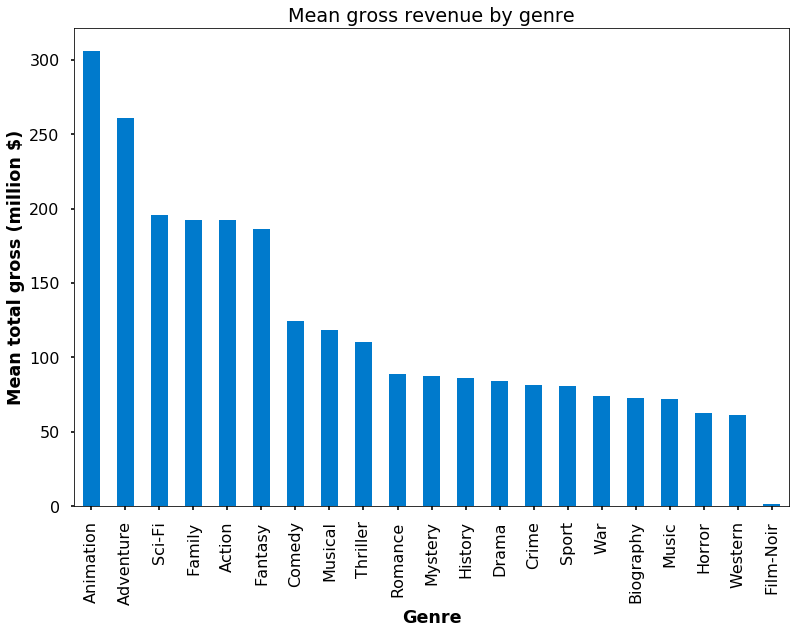

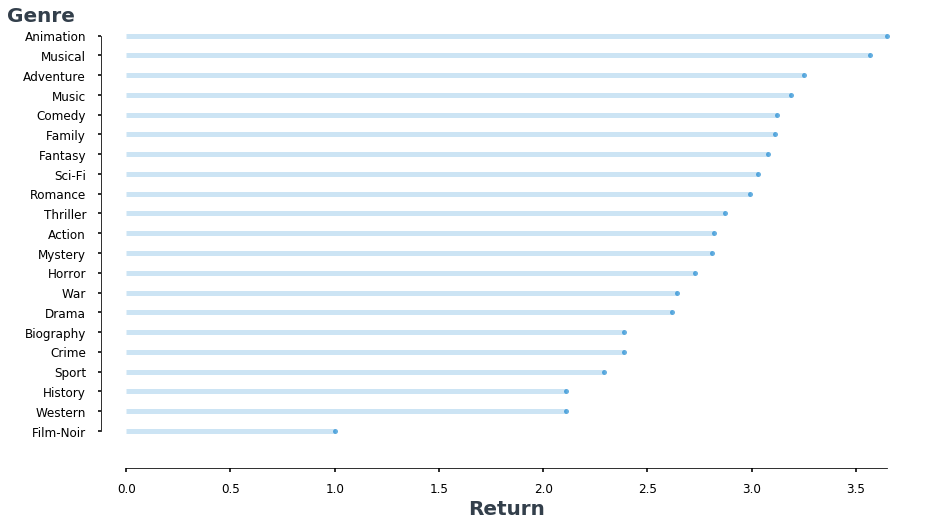

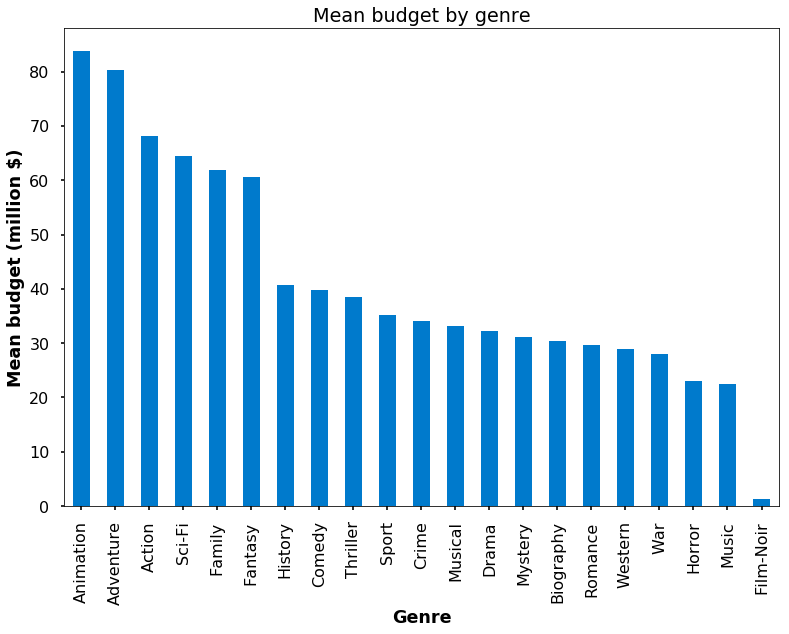

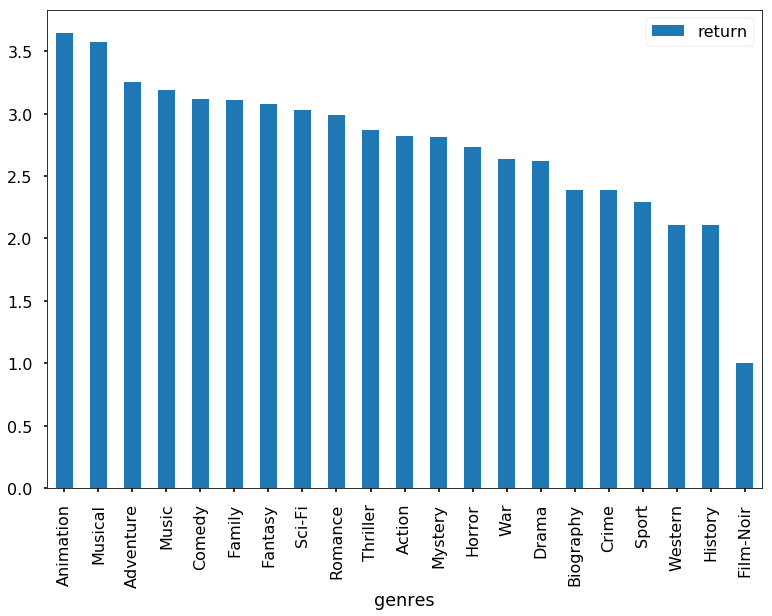

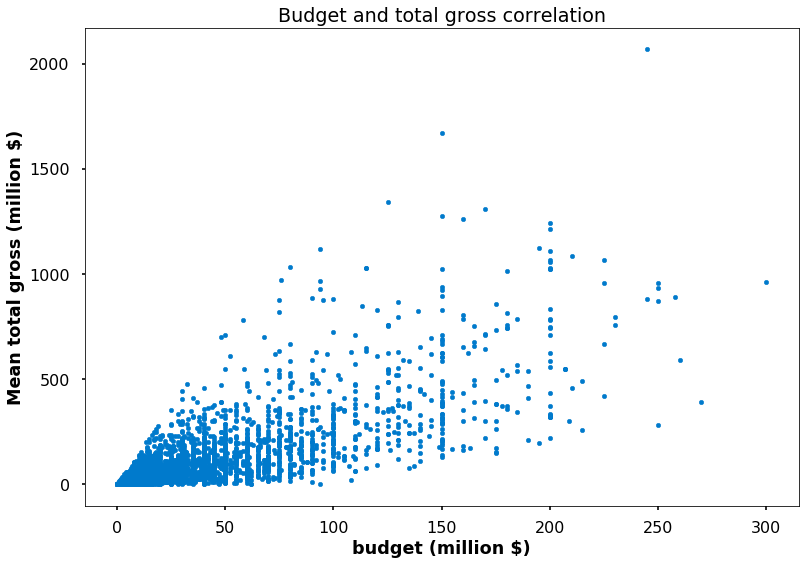

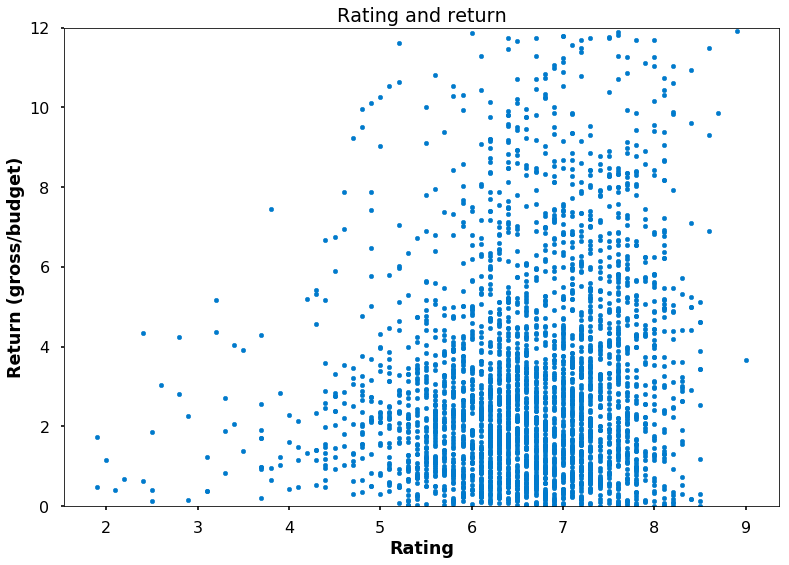

In [25]:
import matplotlib.style as style
style.use('seaborn-poster')

barplot1 = df_money.sort_values('cumulative_world_gross', ascending=False).plot.bar(x='genres', y='cumulative_world_gross', title='Mean gross revenue by genre', legend=False, color = '#007ACC')
# barplot[0].set_color('red')
barplot1.set_ylabel('Mean total gross (million $)', weight='bold')
barplot1.set_xlabel('Genre', weight='bold')





df_money = df_money.sort_values(by='return')
my_range = list(range(1,len(df_money.index)+1))
fig, ax = plt.subplots(figsize=(15,8))
plt.hlines(y=my_range, xmin=0, xmax=df_money['return'], color='#007acc', alpha=0.2, linewidth=5)
plt.plot(df_money['return'], my_range, "o", markersize=5, color='#007ACC', alpha=0.6)
ax.set_xlabel('Return', fontsize=20, fontweight='black', color = '#333F4B')
ax.set_ylabel('')
ax.tick_params(axis='both', which='major', labelsize=12)
plt.yticks(my_range, df_money.index)
fig.text(0.05, 0.87, 'Genre', fontsize=20, fontweight='black', color = '#333F4B')
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.spines['left'].set_smart_bounds(True)
ax.spines['bottom'].set_smart_bounds(True)
ax.spines['bottom'].set_position(('axes', -0.04))
ax.spines['left'].set_position(('axes', 0.015))


barplot2 = df_money.sort_values('budget', ascending=False).plot.bar(x='genres', y='budget', title='Mean budget by genre', legend=False, color = '#007ACC')
# barplot[0].set_color('red')
barplot2.set_ylabel('Mean budget (million $)', weight='bold')
barplot2.set_xlabel('Genre', weight='bold')

df_money.sort_values('return', ascending=False).plot.bar(x='genres', y='return')



scatter1 = df_master.plot.scatter(x='budget', y='cumulative_world_gross', title='Budget and total gross correlation', legend=False, color = '#007ACC')
# barplot[0].set_color('red')
scatter1.set_ylabel('Mean total gross (million $)', weight='bold')
scatter1.set_xlabel('budget (million $)', weight='bold')

scatter2 = df_master.plot.scatter(x='rating', y='return', title='Rating and return', legend=False, color = '#007ACC')
# barplot[0].set_color('red')
scatter2.set_ylabel('Return (gross/budget)', weight='bold')
scatter2.set_ylim([0,12])
scatter2.set_xlabel('Rating', weight='bold')




ax = sns.boxplot(y='return', data=df_master).set_title('Boxplots of return (Total gross / budget)')
ax.set_ylabel('Return')

## Machine Learning
Importing the relevant packages

In [26]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error as mse
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

### Defining the features and target from our dataframe

In [100]:
X = df_master[['budget', 'rating', 'runtime', *list(categories)]].values
X_r = df_master[['rating', 'runtime', *list(categories)]].values
y = df_master['cumulative_world_gross'].values
y_r = df_master['cumulative_world_gross']/df_master['budget'].values

from sklearn.model_selection import train_test_split

## Creating a baseline for our predictions

First we create a split with a development set and a test set. Afterwards we predict the target of our testset with the mean of our development set to see how accurate a simple prediction would be.

In [121]:
X_r_dev, X_r_test, y_r_dev, y_r_test = train_test_split(X_r, y_r, test_size=1/3, random_state=1)
X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=1/3, random_state=1)

### Prediction with the mean

In [126]:
y_pred_stupid = np.repeat(y_dev.mean(),y_test.shape[0])
baseline_rmse = rmse(y_pred_stupid,y_test)
baseline_rmse

171.8730292596556

In [127]:
y_pred_stupid = np.repeat(y_r_dev.mean(),y_r_test.shape[0])
baseline_r_rmse = rmse(y_pred_stupid,y_r_test)
baseline_r_rmse

2.707363826011059

### Prediction with a simple linear regression
The same procedure is done with a simple linear regression, and finally the rmse is found as a measurement for accuracy for the two predictions.

In [149]:
y_pred_linreg = LinearRegression().fit(X_dev,y_dev).predict(X_test)
baseline_rmse_linreg = rmse(y_pred_linreg,y_test)
baseline_rmse_linreg

112.6123617178511

In [132]:
y_r_pred_linreg = LinearRegression().fit(X_r_dev,y_r_dev).predict(X_r_test)
baseline_r_rmse_linreg = rmse(y_r_pred_linreg,y_r_test)
baseline_r_rmse_linreg

2.640512676721401

### Can our validation data work as an indicator for our test data?

From computing the descriptive statistics of RMSE for the train data on  the test and validation data we can conclude we can split the train data and use this to fit the model. This is because the descriptive statistics are quite similar and we therefore presume our split i generalizing enough. (Balanced).

In [159]:
def rmse(y_pred, y_true):
    return np.sqrt(mse(y_pred, y_true))

output=[]

for random_state in range(10):
    X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=1/3, random_state=1)
    X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size=1/2, random_state=1)
    
    reg = LinearRegression().fit(X_train, y_train)
    reg.predict(X_test)
    
    output.append([rmse(reg.predict(X_val), y_val),
                  rmse(reg.predict(X_test), y_test)])
    
print(pd.DataFrame(output, columns=['test', 'validation']))

print(pd.DataFrame(output, columns=['test', 'validation']).describe())

        test  validation
0  118.58519  112.916361
1  118.58519  112.916361
2  118.58519  112.916361
3  118.58519  112.916361
4  118.58519  112.916361
5  118.58519  112.916361
6  118.58519  112.916361
7  118.58519  112.916361
8  118.58519  112.916361
9  118.58519  112.916361
               test    validation
count  1.000000e+01  1.000000e+01
mean   1.185852e+02  1.129164e+02
std    2.995911e-14  2.995911e-14
min    1.185852e+02  1.129164e+02
25%    1.185852e+02  1.129164e+02
50%    1.185852e+02  1.129164e+02
75%    1.185852e+02  1.129164e+02
max    1.185852e+02  1.129164e+02


## Making an OLS-model

In [162]:
from sklearn.model_selection import KFold
kfolds = KFold(n_splits=10) #Splits the data 10 times into evenly sized bins. 
folds = list()

rmseCV = []
perform = []

for train_idx, val_idx in kfolds.split(X_dev, y_dev):        
    # train model and compute MSE on test fold
    pipe_OLSCV = make_pipeline(ColumnTransformer(
                                [("Continous", make_pipeline(
                                     StandardScaler(),
                                     PolynomialFeatures()
                                 ), [0,2]), 
                                  ("", 'passthrough', [i for i in range(3, X.shape[1])])
                                 ]),
                                LinearRegression())
    X_train, y_train, = X_dev[train_idx], y_dev[train_idx] #Selection where we throw in the indices and take out the data
    X_val, y_val = X_dev[val_idx], y_dev[val_idx] 
    pipe_OLSCV.fit(X_train, y_train)  #Fit the model on the training data, estimation
    rmseCV.append(rmse(pipe_OLSCV.predict(X_val), y_val))   #Apply the model to the validation data and store it in an empty list
#y_val_pred = pipe_lassoCV.predict(X_val)
#y_train_pred = pipe_lassoCV.predict(X_train)
#y_test_pred = pipe_lassoCV.predict(X_test)
#perform.append(mse(y_pred, y_val))
# store result    
rmseCV.append(sum(rmseCV_)/len(rmseCV_)) 

rmseCV


[133.78127117761198,
 160.2612704301322,
 121.67017666532648,
 139.58839650083547,
 101.47725090653476,
 96.77768684524716,
 118.93490133304003,
 110.01840430947999,
 81.19143614930003,
 109.54915961733968,
 181.03809096967595]

In [31]:
pipe_OLSCV.named_steps['linearregression'].coef_

array([ 6.70508322e-13,  1.01512782e+02,  2.12994205e+01,  9.22549668e+00,
        8.01304967e+00, -4.60325093e+00,  1.42108547e-14, -5.64156669e+00,
        2.13946130e+01,  2.74322843e+00, -6.48635447e+01, -4.18426835e+00,
       -1.50477910e+01,  1.67463618e+00,  7.31710800e+01, -2.95905628e+00,
       -3.40964328e+01, -2.07903917e+00,  5.02715726e+01, -1.60337522e+01,
       -3.12038614e+01,  4.70884998e+00, -1.18238856e+00,  4.86740295e+00,
       -2.56900363e+01, -1.48098553e+01, -1.93892910e+01])

## Making an OLS-model with LASSO


In [135]:
from sklearn.model_selection import KFold
kfolds = KFold(n_splits=10) #Splits the data 10 times into evenly sized bins. 
folds = list()

lambdas = np.logspace(-2,4,50)
# outer loop: lambdas
rmseCV = []
perform = []

for lambda_ in lambdas:    
    # inner loop: folds. For each of the folds (Splits),
    rmseCV_ = []    
    for train_idx, val_idx in kfolds.split(X_dev, y_dev):        
        # train model and compute MSE on test fold
        pipe_lassoCV = make_pipeline(ColumnTransformer(
                                    [("Continous", make_pipeline(
                                         StandardScaler(),
                                         PolynomialFeatures()
                                     ), [0,2]), 
                                      ("", 'passthrough', [i for i in range(3, X.shape[1])])
                                     ]),
                                    Lasso(alpha=lambda_, random_state=1))
        X_train, y_train, = X_dev[train_idx], y_dev[train_idx] #Selection where we throw in the indices and take out the data
        X_val, y_val = X_dev[val_idx], y_dev[val_idx] 
        pipe_lassoCV.fit(X_train, y_train)  #Fit the model on the training data, estimation
        rmseCV_.append(rmse(pipe_lassoCV.predict(X_val), y_val))   #Apply the model to the validation data and store it in an empty list
    #y_val_pred = pipe_lassoCV.predict(X_val)
    #y_train_pred = pipe_lassoCV.predict(X_train)
    #y_test_pred = pipe_lassoCV.predict(X_test)
    #perform.append(mse(y_pred, y_val))
    # store result    
    rmseCV.append(sum(rmseCV_)/len(rmseCV_)) 
    
# convert to DataFrame
lambdaCV = pd.DataFrame(rmseCV, index=lambdas)

lambdaCV

optimal_lambda = lambdaCV.mean(axis=1).nsmallest(1)
optimal_lambda

0.517947    117.090808
dtype: float64

In [142]:
pipe_final = make_pipeline(ColumnTransformer(
                            [("Continous", make_pipeline(
                                 StandardScaler(),
                                 PolynomialFeatures()
                             ), [0,2]), 
                              ("", 'passthrough', [i for i in range(3, X.shape[1])])
                             ]),
                            Lasso(alpha=0.517947, random_state=1))



In [143]:
the_fit = pipe_final.fit(X_dev, y_dev)

the_fit.named_steps['lasso'].coef_

array([  0.        , 104.46029095,  15.71718813,   8.12198006,
         7.77477825,  -2.50930625,   0.        ,  -0.        ,
        22.64019432,   0.        ,  -0.        ,   0.        ,
       -11.02596797,   3.96916058,  62.04423127,   0.        ,
       -14.71073065,  -0.        ,   0.        ,  -6.51951277,
       -24.66313545,   2.57730919,   0.        ,   0.62064198,
        -0.        ,  -5.73246796, -13.31544465])

In [150]:
y_pred_lasso = the_fit.predict(X_test)
rmse_ml = rmse(y_pred_lasso,y_test)

rmse_ml

113.39138280145382

In [148]:
(baseline_rmse,baseline_rmse_linreg,rmse_ml)

(171.8730292596556, 112.6123617178511, 113.39138280145382)

In [151]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = \
    learning_curve(estimator=pipe_lassoCV,
                   X=X_train,
                   y=y_train,
                   train_sizes=np.arange(0.2, 1, .01),
                   scoring='neg_mean_squared_error',                 
                   cv=3)
    
mse_ = pd.DataFrame({'Train':-train_scores.mean(axis=1),
                     'Test':-test_scores.mean(axis=1)})\
        .set_index(pd.Index(train_sizes,name='sample size'))    
print(mse_.head(3))

                    Train          Test
sample size                            
254          38611.859115  34338.327737
266          37538.764717  34332.664883
279          36734.761059  34320.166235


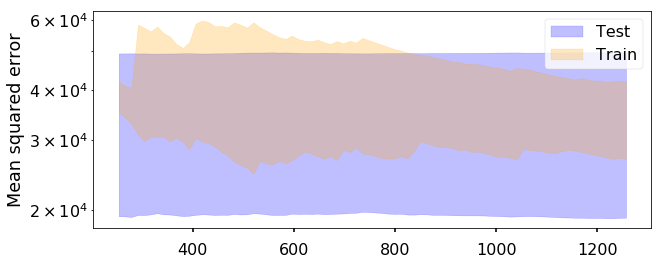

In [111]:
f_learn, ax = plt.subplots(figsize=(10,4))
ax.fill_between(train_sizes,
                -test_scores.mean(1) + test_scores.std(1)*1.96,
                -test_scores.mean(1) - test_scores.std(1)*1.96, 
                alpha=0.25, label ='Test', color='blue')

ax.fill_between(train_sizes,
                -train_scores.mean(1) + train_scores.std(1)*1.96,
                -train_scores.mean(1) - train_scores.std(1)*1.96, 
                alpha=0.25, label='Train', color='orange')
ax.set_ylabel('Mean squared error')
ax.set_yscale('log')
ax.legend()

In [112]:
from sklearn.model_selection import validation_curve

train_scores, test_scores = \
    validation_curve(estimator=pipe_lassoCV,
                     X=X_dev,
                     y=y_dev,
                     param_name='lasso__alpha',
                     param_range=lambdas,
                     scoring='neg_mean_squared_error',                 
                     cv=3)

mse_score = pd.DataFrame({'Train':-train_scores.mean(axis=1),
                          'Validation':-test_scores.mean(axis=1),
                          'lambda':lambdas})\
              .set_index('lambda')   
print(mse_score.Validation.nsmallest(1))

lambda
0.09541    14225.121948
Name: Validation, dtype: float64


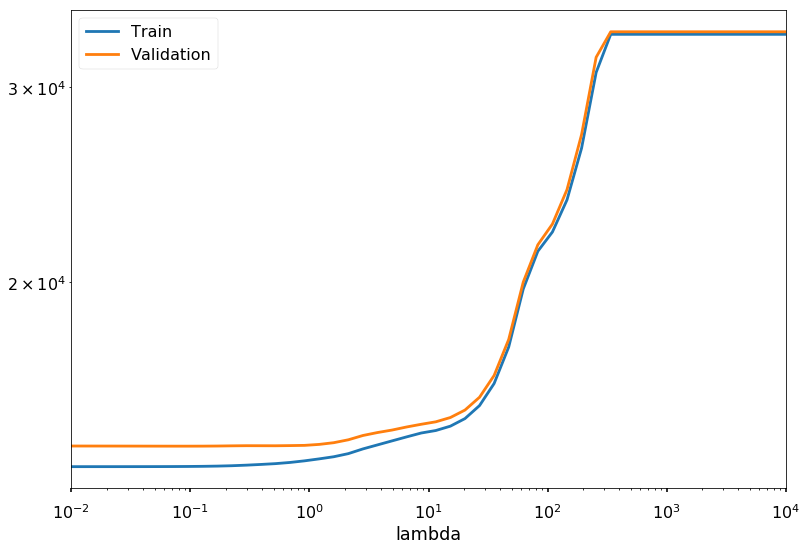

In [113]:
mse_score.plot(logx=True, logy=True)

#overfitter fordi den er bedre på train end validation

## Prediction of the cumulative gross in relation to the budget

In [40]:
def rmse(y_pred, y_true):
    return np.sqrt(mse(y_pred, y_true))

output=[]

for random_state in range(10):
    X_r_dev, X_r_test, y_r_dev, y_r_test = train_test_split(X_r, y_r, test_size=1/3, random_state=1)
    X_r_train, X_r_val, y_r_train, y_r_val = train_test_split(X_r_dev, y_r_dev, test_size=1/2, random_state=1)
    
    reg = LinearRegression().fit(X_r_train, y_r_train)
    reg.predict(X_r_test)
    
    output.append([rmse(reg.predict(X_r_val), y_r_val),
                  rmse(reg.predict(X_r_test), y_r_test)])

print(pd.DataFrame(output, columns=['test', 'validation']))

print(pd.DataFrame(output, columns=['test', 'validation']).describe())

       test  validation
0  2.712349    2.667886
1  2.712349    2.667886
2  2.712349    2.667886
3  2.712349    2.667886
4  2.712349    2.667886
5  2.712349    2.667886
6  2.712349    2.667886
7  2.712349    2.667886
8  2.712349    2.667886
9  2.712349    2.667886
               test    validation
count  1.000000e+01  1.000000e+01
mean   2.712349e+00  2.667886e+00
std    4.681111e-16  4.681111e-16
min    2.712349e+00  2.667886e+00
25%    2.712349e+00  2.667886e+00
50%    2.712349e+00  2.667886e+00
75%    2.712349e+00  2.667886e+00
max    2.712349e+00  2.667886e+00


In [164]:
from sklearn.model_selection import KFold
kfolds = KFold(n_splits=10) #Splits the data 10 times into evenly sized bins. 
folds = list()

lambdas = np.logspace(-4,4,10)
# outer loop: lambdas
rmseCV = []
perform = []

for lambda_ in lambdas:    
    # inner loop: folds. For each of the folds (Splits),
    rmseCV_ = []    
    for train_idx, val_idx in kfolds.split(X_r_dev, y_r_dev):        
        # train model and compute MSE on test fold
        pipe_lasso_rCV = make_pipeline(ColumnTransformer(
                                    [("Continous", make_pipeline(
                                         StandardScaler(),
                                         PolynomialFeatures()
                                     ), [0,1]), 
                                      ("", 'passthrough', [i for i in range(2, X_r.shape[1])])
                                     ]),
                                    Lasso(alpha=lambda_, random_state=1))
        X_r_train, y_r_train, = X_r_dev[train_idx], y_r_dev[train_idx] #Selection where we throw in the indices and take out the data
        X_r_val, y_r_val = X_r_dev[val_idx], y_r_dev[val_idx] 
        pipe_lasso_rCV.fit(X_r_train, y_r_train)  #Fit the model on the training data, estimation
        rmseCV_.append(rmse(pipe_lasso_rCV.predict(X_r_val), y_r_val))   #Apply the model to the validation data and store it in an empty list
    #y_val_pred = pipe_lassoCV.predict(X_val)
    #y_train_pred = pipe_lassoCV.predict(X_train)
    #y_test_pred = pipe_lassoCV.predict(X_test)
    #perform.append(mse(y_pred, y_val))
    # store result    
    rmseCV.append(sum(rmseCV_)/len(rmseCV_)) 
    
# convert to DataFrame
lambdaCV = pd.DataFrame(rmseCV, index=lambdas)

lambdaCV

optimal_lambda = lambdaCV.mean(axis=1).nsmallest(1)
optimal_lambda

0.005995    2.715276
dtype: float64

### Creating the pipeline with the optimal lambda

In [79]:
pipe_optimal_r = make_pipeline(ColumnTransformer(
                            [("Continous", make_pipeline(
                                 StandardScaler(),
                                 PolynomialFeatures()
                             ), [0,2]), 
                              ("", 'passthrough', [i for i in range(3, X_r.shape[1])])
                             ]),
                            Lasso(alpha=0.005995, random_state=1))

### Fitting the development set with the optimal pipeline 

In [80]:
fit_r = pipe_optimal_r.fit(X_r_dev, y_r_dev)

### Predicting the test set, and finding the rmse of the model

In [96]:
y_pred_ml = fit_r.predict(X_r_test)
rmse_ml = rmse(y_pred_ml,y_r_test)

### Comparing each rmse to see if our created model is better than the more simple ones

In [118]:
(baseline_rmse,baseline_rmse_linreg,rmse_ml)

(2.707363826011059, 2.640512676721401, 2.622122088697686)

### Looking at the mean absolute error

In [119]:
def mean_abs_err(y_pred,y_test) :
    return np.mean(np.abs(y_test - y_pred))

In [120]:
(mean_abs_err(y_pred_stupid,y_r_test),
 mean_abs_err(y_pred_linreg,y_r_test),
 mean_abs_err(y_pred_ml,y_r_test))

(2.0886791364799513, 2.0087520296391466, 1.9943112362536242)

### Looking at the learning and validation curves to observe over or underfitting

In [44]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = \
    learning_curve(estimator=pipe_lassoCV,
                   X=X_train,
                   y=y_train,
                   train_sizes=np.arange(0.2, 1, .01),
                   scoring='neg_mean_squared_error',         
                   cv=3)
    
mse_ = pd.DataFrame({'Train':-train_scores.mean(axis=1),
                     'Test':-test_scores.mean(axis=1)})\
        .set_index(pd.Index(train_sizes,name='sample size'))    
print(mse_.head(3))

                    Train          Test
sample size                            
254          38611.859115  34338.327737
266          37538.764717  34332.664883
279          36734.761059  34320.166235


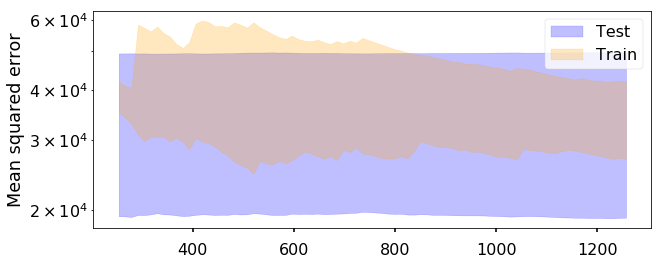

In [45]:
f_learn, ax = plt.subplots(figsize=(10,4))
ax.fill_between(train_sizes,
                -test_scores.mean(1) + test_scores.std(1)*1.96,
                -test_scores.mean(1) - test_scores.std(1)*1.96, 
                alpha=0.25, label ='Test', color='blue')

ax.fill_between(train_sizes,
                -train_scores.mean(1) + train_scores.std(1)*1.96,
                -train_scores.mean(1) - train_scores.std(1)*1.96, 
                alpha=0.25, label='Train', color='orange')
ax.set_ylabel('Mean squared error')
ax.set_yscale('log')
ax.legend()

In [46]:
from sklearn.model_selection import validation_curve

train_scores, test_scores = \
    validation_curve(estimator=pipe_lassoCV,
                     X=X_dev,
                     y=y_dev,
                     param_name='lasso__alpha',
                     param_range=lambdas,
                     scoring='neg_mean_squared_error',                 
                     cv=3)

mse_score = pd.DataFrame({'Train':-train_scores.mean(axis=1),
                          'Validation':-test_scores.mean(axis=1),
                          'lambda':lambdas})\
              .set_index('lambda')   
print(mse_score.Validation.nsmallest(1))

lambda
0.046416    14226.138822
Name: Validation, dtype: float64


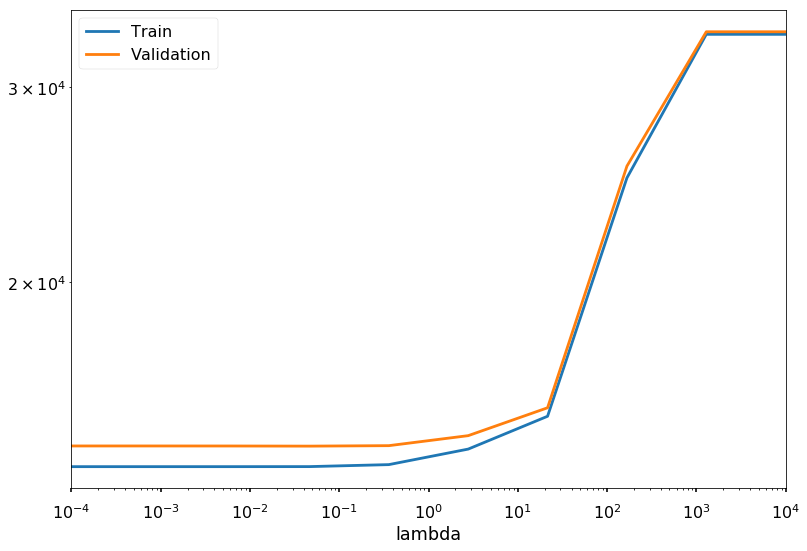

In [47]:
mse_score.plot(logx=True, logy=True)

#overfitter fordi den er bedre på train end validation

# Code for plots

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns

plt.style.use('ggplot')
%matplotlib inline

SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title